In [1]:
import xarray as xr
import numpy as np
from c_error_predictor import BiasPredictor
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

# Running bias predictor using the best sample and default samples from database

In [2]:
# dataset based on minimum squared bias 
xr_data=xr.load_dataset("results_stacked_hh.nc")
# Running predictor for calibrated data
predictor = BiasPredictor(xr_data,cv_mode='shuffled_cv',calibration_mode='min_bias')
results,parameters=predictor.run()
cv_df,cv_df_xgb,cv_df_linear_reduced,cv_df_xgb_reduced = results["linear"],results["xgb"],results["linear_reduced"],results["xgb_reduced"]

# Running predictor for default model parameters
predictor_def = BiasPredictor(xr_data,cv_mode='shuffled_cv',calibration_mode='default')
results_def,parameters_def=predictor_def.run()
cv_df_def,cv_df_xgb_def,cv_df_linear_reduced_def,cv_df_xgb_reduced_def = results_def["linear"],results_def["xgb"],results_def["linear_reduced"],results_def["xgb_reduced"]

Preprocessing the data...
Training the model and evaluating cross validation metrics...
Using K-Fold CV with 10 folds and shuffling.
Preprocessing the data...
Training the model and evaluating cross validation metrics...
Using K-Fold CV with 10 folds and shuffling.


In [3]:
parameters

[{'ss_alpha': 0.7878, 'k_b': 0.0241},
 {'ss_alpha': 0.7878, 'k_b': 0.0241},
 {'ss_alpha': 0.9039, 'k_b': 0.0242},
 {'ss_alpha': 0.7944, 'k_b': 0.0237},
 {'ss_alpha': 0.7878, 'k_b': 0.0241},
 {'ss_alpha': 0.7878, 'k_b': 0.0241},
 {'ss_alpha': 0.9039, 'k_b': 0.0242},
 {'ss_alpha': 0.768, 'k_b': 0.024},
 {'ss_alpha': 0.7509, 'k_b': 0.0236},
 {'ss_alpha': 0.768, 'k_b': 0.024}]

# Comparing Cross Validation Stats for different regression models with and without dimension reduction

In [4]:
def plot_cv_metrics(dfs_combined, metric='r2', ylabel='', ylim=None,plot=True):

    fs=14
    positions = [1, 2]
    box_colors = [plt.rcParams['axes.prop_cycle'].by_key()['color'][0]] * 2 
    fig, ax = plt.subplots(figsize=(6, 5))

    data = [df[metric] for df, _ in dfs_combined]
    bp = ax.boxplot(
        data, positions=positions, widths=0.7, patch_artist=True, showmeans=False, showfliers=False
    )

    ax.set_title("Cross-validation comparison for regression models",fontsize=fs)
    ax.set_ylabel(ylabel, fontsize=fs)
    ax.grid(axis='y')

    # Set box colors
    for patch, color in zip(bp['boxes'], box_colors):
        patch.set_facecolor(color)
    for median in bp['medians']:
        median.set_color('black')

    ax.set_xticks([np.mean(positions[j:j+1]) for j in range(0, len(positions), 1)])
    ax.set_xticklabels(["Linear", "XGB"] ,
                       rotation=0, ha='center', fontsize=fs)
    ax.tick_params(axis='both', labelsize=fs)

    # Set y-axis limits if provided
    if ylim is not None:
        ax.set_ylim(ylim)
    plt.tight_layout()
    if plot:
        plt.savefig(f"cv_bars_{metric}.png")

    plt.show()

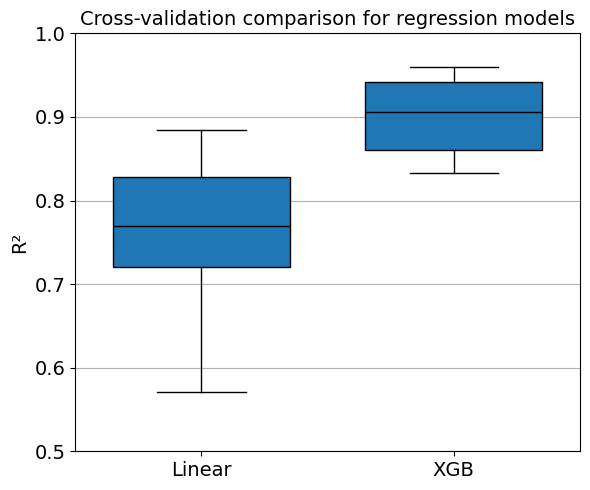

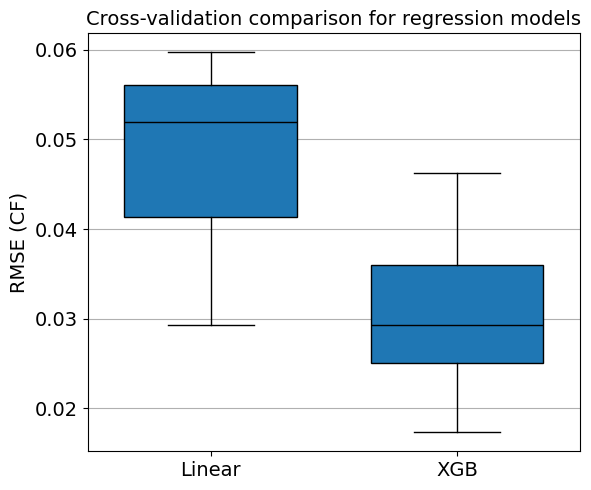

In [5]:
dfs_combined = [
    (cv_df, "Linear (Default)"),
    (cv_df_xgb, "XGB (Default)"),

]
plot_cv_metrics(dfs_combined, metric='r2',ylabel='R²',ylim=([0.5,1]))#
plot_cv_metrics(dfs_combined, metric='rmse', ylabel='RMSE (CF)') #,ylim=([0.01,0.16])
# plot_cv_metrics(dfs_combined, metric='mse', ylabel='MSE (CF²)')
# plot_cv_metrics(dfs_combined, metric='mae', ylabel='MAE (CF)')
# plot_cv_metrics(dfs_combined, metric='pw_bias', ylabel='PW Bias (CF)')
# plot_cv_metrics(dfs_combined, metric='pw_bias_corrected', ylabel='PW Bias (Corrected) (CF)')

# Choosing best predictor (xgb) and comparing 4 model levels
4 model levels:
- pywake default parameters
- pywake calibrated parameters
- pywake default parameters + bias correction
- pywake calibrated parameters + bias correction




In [6]:
bias_default=cv_df_xgb_def['pw_bias']
bias_default_corrected=cv_df_xgb_def['pw_bias_corrected']
bias_calibrated=cv_df_xgb['pw_bias']
bias_calibrated_corrected=cv_df_xgb['pw_bias_corrected']

/tmp/ipykernel_189305/1495819699.py:14: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = plt.boxplot(biases, labels=xlabels, patch_artist=True)


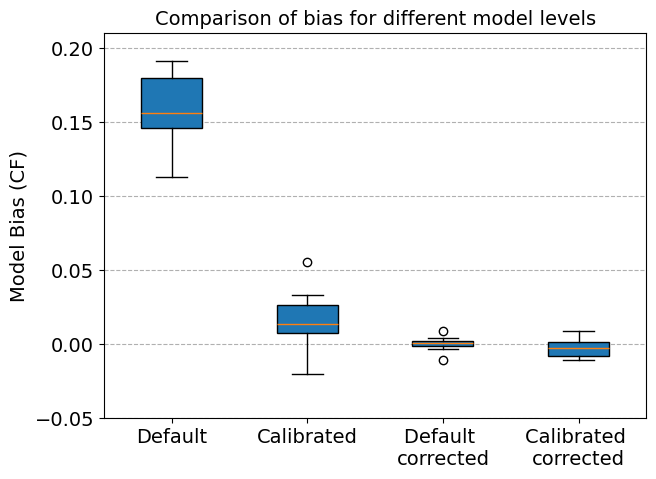

In [7]:
biases = [
    bias_default,
    bias_calibrated,
    bias_default_corrected,
    bias_calibrated_corrected
]

fs=14
xlabels = ['Default','Calibrated','Default \ncorrected','Calibrated \ncorrected']

plt.figure(figsize=(7,5))

# Draw the boxplots
box = plt.boxplot(biases, labels=xlabels, patch_artist=True)

# # Compute and overlay means
# means = [np.mean(b) for b in biases]
# plt.plot(range(1, len(means)+1), means, 'o', color='red', label='Mean')

plt.ylabel("Model Bias (CF)",fontsize=fs)
plt.title("Comparison of bias for different model levels",fontsize=fs)
plt.grid(axis='y', linestyle='--')
plt.xticks(fontsize=fs)
plt.yticks(fontsize=fs)
plt.ylim([-0.05,0.21])
# plt.legend()
plt.savefig(f"cv_bars_bias.png")
plt.show()

# Effect of calibration on distribution of bias

In [15]:
bias_array = xr_data.model_bias_cap.values  
# abs_total_bias = np.abs(np.sum(bias_array, axis=1))
# idx = np.argmin(abs_total_bias)  

mses = np.round(np.mean(bias_array**2, axis=1),4)
idx = np.argmin(mses) 

bias_cal=bias_array[idx,:]
bias_default=bias_array[0,:]

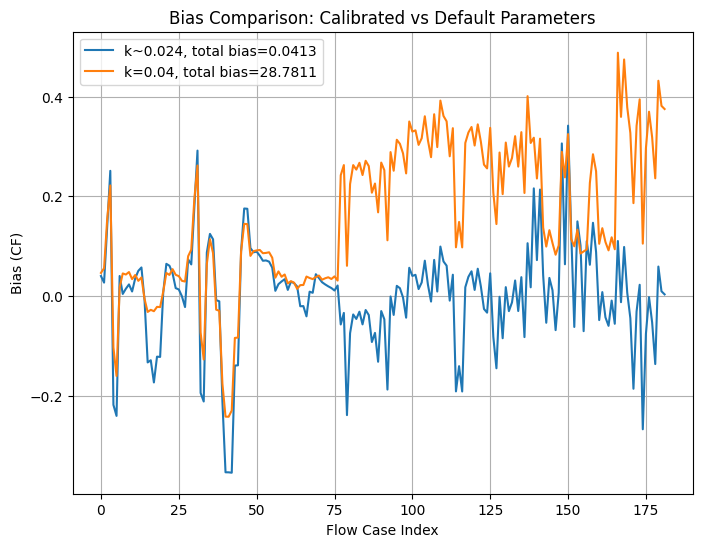

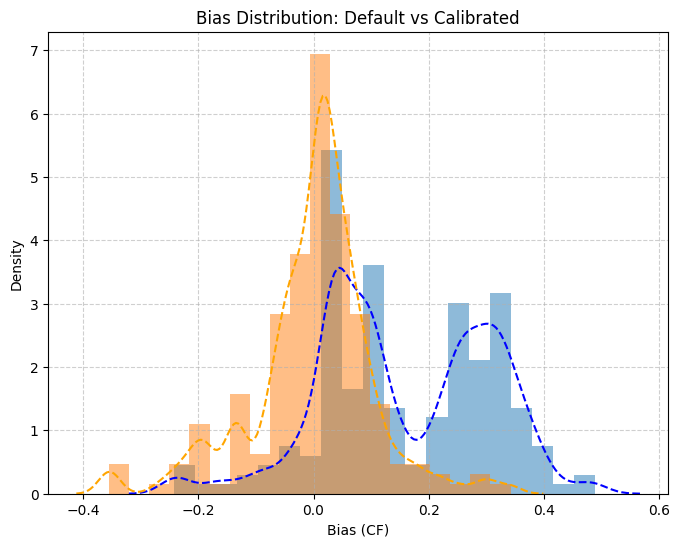

In [24]:
# Calibrating on the whole dataset here

bias_array = xr_data.model_bias_cap.values  
abs_total_bias = np.abs(np.sum(bias_array, axis=1))
idx = np.argmin(abs_total_bias)  
total_bias_value_cal=abs_total_bias[idx]
total_bias_value_def=abs_total_bias[0]

# mses = np.round(np.mean(bias_array**2, axis=1),4)
# idx = np.argmin(mses) 
# mse_value_cal=mses[idx]
# mse_value_def=mses[0]

bias_cal=bias_array[idx,:]
bias_default=bias_array[0,:]


plt.figure(figsize=(8,6))
plt.plot(bias_cal,label=f"k~0.024, total bias={total_bias_value_cal:.4f}")  #mse={mse_value_cal:.4f}"  
plt.plot(bias_default,label=f"k=0.04, total bias={total_bias_value_def:.4f}") #mse={mse_value_def:.4f}"
plt.ylabel("Bias (CF)")
plt.xlabel("Flow Case Index")
plt.title("Bias Comparison: Calibrated vs Default Parameters")
plt.grid()
plt.legend()

import seaborn as sns
import matplotlib.pyplot as plt


plt.figure(figsize=(8,6))

plt.hist(bias_default, bins=20, alpha=0.5, label=f"Default k=0.04", density=True)
plt.hist(bias_cal, bins=20, alpha=0.5, label=f"Calibrated k~0.024", density=True)

# Optional KDE / curve fitting
sns.kdeplot(bias_default, bw_adjust=0.5, color='blue', linestyle='--')
sns.kdeplot(bias_cal, bw_adjust=0.5, color='orange', linestyle='--')

plt.xlabel("Bias (CF)")
plt.ylabel("Density")
plt.title("Bias Distribution: Default vs Calibrated")
plt.grid(True, linestyle='--', alpha=0.6)
# plt.legend()
plt.show()